# Intro

This notebook shows how to predict the sale price for a house using a neural network implemented with PyTorch.

# Read in a dataset

In [1]:
import pandas
t = pandas.read_csv("houses.csv")

In [2]:
t

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


# Prepare example data

In [3]:
x = t[ ["LotArea", "OverallQual", "YearBuilt" ]]

In [4]:
x

,LotArea,OverallQual,YearBuilt
0,8450,7,2003
1,9600,6,1976
2,11250,7,2001
3,9550,7,1915
4,14260,8,2000
...,...,...,...
1455,7917,6,1999
1456,13175,6,1978
1457,9042,7,1941
1458,9717,5,1950


In [5]:
y = t[ ["SalePrice"] ]

In [6]:
y

,SalePrice
0,208500
1,181500
2,223500
3,140000
4,250000
...,...
1455,175000
1456,210000
1457,266500
1458,142125


# Scale example data

Check whether scikit-learn is installed:

In [7]:
!pip list | grep learn

scikit-learn                 1.0.2


In [8]:
from sklearn.preprocessing import MinMaxScaler
x_scaler = MinMaxScaler()
y_scaler  = MinMaxScaler()
x_scaled = x_scaler.fit_transform( x )
y_scaled = y_scaler.fit_transform( y )

In [9]:
x_scaled

array([[0.0334198 , 0.66666667, 0.94927536],
       [0.03879502, 0.55555556, 0.75362319],
       [0.04650728, 0.66666667, 0.93478261],
       ...,
       [0.03618687, 0.66666667, 0.5       ],
       [0.03934189, 0.44444444, 0.56521739],
       [0.04037019, 0.44444444, 0.67391304]])

In [10]:
y_scaled

array([[0.24107763],
       [0.20358284],
       [0.26190807],
       ...,
       [0.321622  ],
       [0.14890293],
       [0.15636717]])

# Split example data into train and test data

In [11]:
nr_train_samples = 1000

x_train = x_scaled[:nr_train_samples]
y_train = y_scaled[:nr_train_samples]

x_test = x_scaled[nr_train_samples:]
y_test = y_scaled[nr_train_samples:]

In [12]:
x_train.shape

(1000, 3)

In [13]:
x_test.shape

(460, 3)

In [14]:
y_train.shape

(1000, 1)

In [15]:
y_test.shape

(460, 1)

In [16]:
print("One training example")
print( f"{x_train[0]} --> {y_train[0]}" )

One training example
[0.0334198  0.66666667 0.94927536] --> [0.24107763]


# Prepare a neural network class using PyTorch

In [17]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# Define a neural net
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # note: order of generated layers here does not matter!       
        # it is the order of layers in forward() that does matter.
        # see: https://discuss.pytorch.org/t/can-i-change-the-order-of-layers-in-init/105027:
        #
        #  "It doesn’t matter. forward is which defines the real order. 
        #   The only difference is they will be displayed differently 
        #   when you print the model or save it."
        #
        self.fc1 = nn.Linear(3, 20)
        self.actfunc = torch.nn.ReLU()
        #self.actfunc = torch.nn.Sigmoid()
        self.fc2 = nn.Linear(20, 1)        

    def forward(self, input_vec):
        x = self.fc1(input_vec)
        x = self.actfunc(x)
        x = self.fc2(x)
        return x

In [18]:
net = NeuralNet()

In [19]:
type(net)

__main__.NeuralNet

In [20]:
print(net)

NeuralNet(
  (fc1): Linear(in_features=3, out_features=20, bias=True)
  (actfunc): ReLU()
  (fc2): Linear(in_features=20, out_features=1, bias=True)
)


In [21]:
type( net.fc1 )

torch.nn.modules.linear.Linear

# Get the weights for one layer

In [22]:
type(net.fc1.weight)

torch.nn.parameter.Parameter

In [23]:
net.fc1.weight

Parameter containing:
tensor([[-0.3598,  0.2796, -0.3197],
        [-0.0288,  0.4129,  0.2385],
        [-0.5363, -0.4216,  0.0312],
        [-0.1906, -0.5004,  0.2271],
        [-0.3826,  0.3803,  0.0006],
        [-0.4599,  0.3380,  0.1384],
        [-0.5225, -0.1625,  0.2092],
        [-0.2642, -0.2497,  0.1957],
        [-0.2964,  0.5148, -0.2456],
        [ 0.3415,  0.4672,  0.1179],
        [ 0.4568,  0.2792,  0.5315],
        [-0.1179,  0.2690,  0.1200],
        [ 0.0164,  0.0041, -0.1546],
        [-0.4405,  0.0190, -0.3462],
        [ 0.5549, -0.4905,  0.0051],
        [-0.5723,  0.0687, -0.3790],
        [ 0.3029, -0.2273,  0.5474],
        [-0.5167,  0.1080,  0.3329],
        [-0.3088,  0.2421,  0.3884],
        [-0.0713,  0.0149,  0.1276]], requires_grad=True)

In [24]:
net.fc1.weight.dtype

torch.float32

In [25]:
net.fc1.bias

Parameter containing:
tensor([ 0.0953,  0.2083, -0.1617,  0.1048,  0.0434,  0.2894, -0.0384,  0.1766,
         0.1314, -0.4130, -0.1133,  0.0292, -0.0603, -0.3857,  0.0229, -0.2495,
         0.1515, -0.0916, -0.0052,  0.5115], requires_grad=True)

In [26]:
net.fc1.bias.dtype

torch.float32

In [27]:
for parameter in net.fc1.parameters():
    print(parameter)

Parameter containing:
tensor([[-0.3598,  0.2796, -0.3197],
        [-0.0288,  0.4129,  0.2385],
        [-0.5363, -0.4216,  0.0312],
        [-0.1906, -0.5004,  0.2271],
        [-0.3826,  0.3803,  0.0006],
        [-0.4599,  0.3380,  0.1384],
        [-0.5225, -0.1625,  0.2092],
        [-0.2642, -0.2497,  0.1957],
        [-0.2964,  0.5148, -0.2456],
        [ 0.3415,  0.4672,  0.1179],
        [ 0.4568,  0.2792,  0.5315],
        [-0.1179,  0.2690,  0.1200],
        [ 0.0164,  0.0041, -0.1546],
        [-0.4405,  0.0190, -0.3462],
        [ 0.5549, -0.4905,  0.0051],
        [-0.5723,  0.0687, -0.3790],
        [ 0.3029, -0.2273,  0.5474],
        [-0.5167,  0.1080,  0.3329],
        [-0.3088,  0.2421,  0.3884],
        [-0.0713,  0.0149,  0.1276]], requires_grad=True)
Parameter containing:
tensor([ 0.0953,  0.2083, -0.1617,  0.1048,  0.0434,  0.2894, -0.0384,  0.1766,
         0.1314, -0.4130, -0.1133,  0.0292, -0.0603, -0.3857,  0.0229, -0.2495,
         0.1515, -0.0916, -0.0052, 

# Feed forward one input vector

In [28]:
input_vec = torch.tensor( [1.0,  0.5, 2.0], dtype=torch.float32 )

output = net( input_vec )

In [29]:
input_vec.dtype

torch.float32

In [30]:
output.dtype

torch.float32

In [31]:
type(output)

torch.Tensor

In [32]:
output

tensor([-0.5245], grad_fn=<AddBackward0>)

In [33]:
input_vec 

tensor([1.0000, 0.5000, 2.0000])

In [34]:
net.fc1.weight

Parameter containing:
tensor([[-0.3598,  0.2796, -0.3197],
        [-0.0288,  0.4129,  0.2385],
        [-0.5363, -0.4216,  0.0312],
        [-0.1906, -0.5004,  0.2271],
        [-0.3826,  0.3803,  0.0006],
        [-0.4599,  0.3380,  0.1384],
        [-0.5225, -0.1625,  0.2092],
        [-0.2642, -0.2497,  0.1957],
        [-0.2964,  0.5148, -0.2456],
        [ 0.3415,  0.4672,  0.1179],
        [ 0.4568,  0.2792,  0.5315],
        [-0.1179,  0.2690,  0.1200],
        [ 0.0164,  0.0041, -0.1546],
        [-0.4405,  0.0190, -0.3462],
        [ 0.5549, -0.4905,  0.0051],
        [-0.5723,  0.0687, -0.3790],
        [ 0.3029, -0.2273,  0.5474],
        [-0.5167,  0.1080,  0.3329],
        [-0.3088,  0.2421,  0.3884],
        [-0.0713,  0.0149,  0.1276]], requires_grad=True)

In [35]:
net.fc1.bias

Parameter containing:
tensor([ 0.0953,  0.2083, -0.1617,  0.1048,  0.0434,  0.2894, -0.0384,  0.1766,
         0.1314, -0.4130, -0.1133,  0.0292, -0.0603, -0.3857,  0.0229, -0.2495,
         0.1515, -0.0916, -0.0052,  0.5115], requires_grad=True)

In [36]:
net.fc2.weight

Parameter containing:
tensor([[ 0.1818,  0.0197, -0.1084,  0.0124,  0.0319, -0.1055, -0.2111,  0.1077,
          0.0861,  0.1441, -0.1968, -0.0301,  0.1530, -0.0594,  0.1210,  0.0530,
         -0.0206, -0.0941,  0.0444, -0.1627]], requires_grad=True)

In [37]:
net.fc2.bias

Parameter containing:
tensor([-0.1907], requires_grad=True)

# Prepare gradient descent / neural network training

In [38]:
#loss_function = torch.nn.L1Loss()
loss_function = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
#optimizer = optim.SGD(net.parameters(), lr=0.001)

In [39]:
type(loss_function)

torch.nn.modules.loss.MSELoss

In [40]:
type(optimizer)

torch.optim.adam.Adam

# Generate and train the network

In [41]:
nr_train_samples

1000

In [42]:
import numpy

# prepare neural network
net = NeuralNet()
loss_fn = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

N_train_steps = 20000

losses = []
avg_losses = []
for train_step in range(N_train_steps):   
    
    # 1. get a random training sample
    #    consisting of an input vec and a teacher vec
    random_idx = numpy.random.randint(low=0, high=nr_train_samples)  
    input_vec   = torch.tensor( x_train[random_idx], dtype=torch.float32 )
    teacher_vec = torch.tensor( y_train[random_idx], dtype=torch.float32 )
    
    # 2. sets gradients to 0 before calculating loss   
    # For: net.zero_grad() vs optim.zero_grad() see:    
    # https://stackoverflow.com/questions/61898668/net-zero-grad-vs-optim-zero-grad-pytorch
    #net.zero_grad()
    optimizer.zero_grad()

    # 3. feed forward step
    output_vec = net( input_vec )

    # 4. compute loss
    loss = loss_fn(output_vec, teacher_vec)
    
    # 5. apply this loss backwards thru the network's parameters
    loss.backward() 
    
    # 6. change weights, i.e.
    #    attempt to optimize weights to account for loss/gradients
    optimizer.step() 

    # 7. save loss
    loss_value = loss.detach().numpy()
    losses.append( loss_value )
    if len(losses)>100:
        avg_losses.append( numpy.mean(losses[-100:]) )
    
    # 8 show progress
    if train_step % 1000 == 0:
        print("train_step=", train_step)

train_step= 0
train_step= 1000
train_step= 2000
train_step= 3000
train_step= 4000
train_step= 5000
train_step= 6000
train_step= 7000
train_step= 8000
train_step= 9000
train_step= 10000
train_step= 11000
train_step= 12000
train_step= 13000
train_step= 14000
train_step= 15000
train_step= 16000
train_step= 17000
train_step= 18000
train_step= 19000


# Show training loss curve

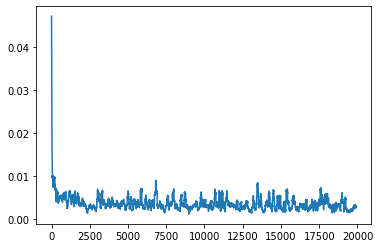

In [43]:
import matplotlib.pyplot as plt
plt.plot( avg_losses )
plt.show()

# Compute model quality

In [44]:
gt_dollar = y_scaler.inverse_transform( y_test )
gt_dollar[:15]

array([[ 82000.],
       [ 86000.],
       [232000.],
       [136905.],
       [181000.],
       [149900.],
       [163500.],
       [ 88000.],
       [240000.],
       [102000.],
       [135000.],
       [100000.],
       [165000.],
       [ 85000.],
       [119200.]])

In [45]:
gt_dollar.shape

(460, 1)

In [46]:
preds = numpy.zeros( gt_dollar.shape )

In [47]:
preds.shape

(460, 1)

In [48]:
preds[:15]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [49]:
net.eval()

with torch.no_grad():

    for i in range(0, len(x_test) ):
        input_vec = torch.tensor( x_test[i], dtype=torch.float32 )
        output_vec = net( input_vec )
        preds[i,:] = output_vec.detach().numpy()

In [50]:
preds[:15]

array([[0.07709105],
       [0.0912568 ],
       [0.3255761 ],
       [0.13912982],
       [0.20169546],
       [0.12259288],
       [0.16413578],
       [0.06334963],
       [0.2418779 ],
       [0.09485006],
       [0.18271729],
       [0.12635528],
       [0.15145549],
       [0.10041466],
       [0.1587026 ]])

In [51]:
preds_dollar = y_scaler.inverse_transform( preds )
preds_dollar[:15]

array([[ 90413.26735765],
       [100614.02511075],
       [269347.34728634],
       [135087.38157153],
       [180140.89865834],
       [123179.13383991],
       [153094.17799413],
       [ 80518.06637272],
       [209076.27476305],
       [103201.52523443],
       [166474.72305   ],
       [125888.43389601],
       [143963.09963167],
       [107208.59922469],
       [149181.74011558]])

In [52]:
MAE_in_dollar = numpy.mean(abs(gt_dollar - preds_dollar))
MAE_in_dollar

27747.97342096859

In [53]:
print( f"We can estimate the sale price of an unknown house with an average error of {MAE_in_dollar}" )

We can estimate the sale price of an unknown house with an average error of 27747.97342096859
